# Microsimulation with artificial survey data 

In [1]:
import matplotlib.pyplot as plt  # For graphics
%matplotlib inline

import numpy as np  # linear algebra and math
import pandas as pd  # data frames

from openfisca_core.model_api import *
from openfisca_senegal import SenegalTaxBenefitSystem  # The Senegalese tax-benefits system

from openfisca_senegal.survey_scenarios import SenegalSurveyScenario

libyaml is not installed in your environment. This can make OpenFisca slower to start. Once you have installed libyaml, run 'pip uninstall pyyaml && pip install pyyaml --no-cache-dir' so that it is used in your Python environment.



## Building the artificial data

Sénégal is composed by almost 15 millions people dispatched in around 1.6 million household

In [2]:
year = 2017
household_weight = 100
size = int(1.6e6 / household_weight)
print("Size of the sample: {}".format(size))
np.random.seed(seed = 42)

Size of the sample: 16000


We assume that 2/3 of the household heads are married and that only married houshold do have children. The mean number of children per household is 5 and is normally distributed

In [3]:
est_marie = np.random.binomial(1, .66, size = size)
est_celibataire = np.logical_not(est_marie)
nombre_enfants = np.maximum(
    est_marie * np.round(np.random.normal(5, scale = 3, size = size)),
    0,
    )

We assume that 80% of the population are wage earners.
We choose a mean wage of 5 000 0000 CFA with a log normal ditribution.
Since 
$$ \text{mean wage}  = e^{\mu + \frac{\sigma ^ 2}{2}} $$ 
and
$$ \text{median wage} = e^\mu $$
we can compute the distribution according to the following expressions.

In [4]:
mean_wage = 5e6
median_wage = .75 * mean_wage
est_salarie = np.random.binomial(1, .8, size = size)
mu = np.log(median_wage)
sigma = np.sqrt(2 * np.log(mean_wage / median_wage))
salaire = (
    est_salarie * 
    np.random.lognormal(mean = mu, sigma = sigma, size = int(size))
    )


We choose a mean pension of 2 500 000 CFA

In [5]:
mean_pension = 2.5e6
median_pension = .9 * mean_pension

In [6]:
mu = np.log(median_pension)
sigma = np.sqrt(2 * np.log(mean_pension / median_pension))
pension_retraite = (
    np.logical_not(est_salarie) *
    np.random.lognormal(mean = mu, sigma = sigma, size = int(size))
    )

In [7]:
input_data_frame = pd.DataFrame({
    'est_marie': est_marie,
    'est_celibataire': est_celibataire,
    'nombre_enfants': nombre_enfants,
    'pension_retraite': pension_retraite,
    'salaire': salaire,
    'id_menage': range(size),
    'role_menage': 0,
    })

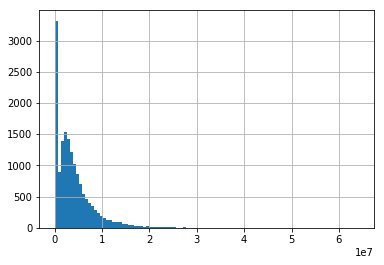

In [8]:
input_data_frame.salaire.hist(bins=100)

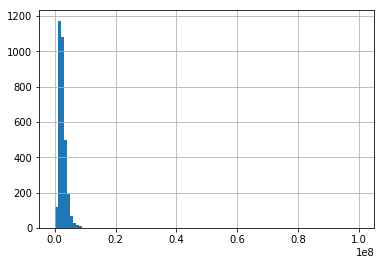

In [9]:
input_data_frame.pension_retraite.hist(bins=100, range = [.0001, 1e8])

## Microsimulation 

As with test case, we can build a scenario with survey data

In [10]:
data = dict(input_data_frame = input_data_frame)
scenario = SenegalSurveyScenario(
    year = year,
    data = data,
    )

/home/benjello/openfisca/openfisca-core/openfisca_core/entities.py:333: Warning: entity.roles_count is deprecated. Since OpenFisca Core 23.0, this attribute has strictly no effect, and it is not necessary to set it.
  Warning
/home/benjello/openfisca/openfisca-core/openfisca_core/entities.py:321: Warning: entity.roles_count is deprecated. Since OpenFisca Core 23.0, this attribute has strictly no effect, and it is not necessary to set it.
  Warning


We can compute the value of any variable for the whole population an draw distributions

In [11]:
scenario.simulation.calculate('impot_revenus', period = year)

array([     0., 221100., 974400., ..., 233100., 933800., 309600.],
      dtype=float32)

In [12]:
df = pd.DataFrame({'impot_revenus': scenario.simulation.calculate('impot_revenus', period = year)})

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6af89adb38>]],
      dtype=object)

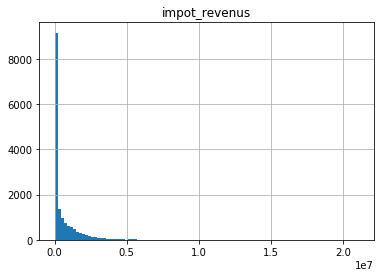

In [31]:
df.hist(bins = 100)

Special methods allow access to aggregates and pivot tables

In [32]:
scenario.compute_aggregate('impot_revenus', period = year) / 1e9

9.673498624

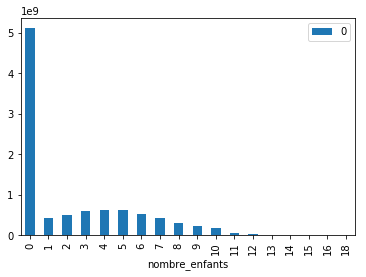

In [33]:
scenario.compute_pivot_table(
    aggfunc = 'sum', 
    values = ['impot_revenus'], 
    columns = ['nombre_enfants'],
    period = year,
    ).stack().reset_index().plot(x = 'nombre_enfants', kind = 'bar')

# Evaluate the financial impact of a reform

Write a parametric reform tthat increseases the top marginal tax rates and evaluate how much revenue can be collected

In [34]:
def modify_parameters(parameters):
    parameters.bareme_impot_progressif[5].rate.update(period = period(year), value = .5)
    return parameters
    
class tax_the_rich(Reform):
    name = u"Tax last bracket at 50%"

    def apply(self):
        self.modify_parameters(modifier_function = modify_parameters)

In [35]:
senegal_tax_benefit_system = SenegalTaxBenefitSystem()
tax_the_rich_tax_benefit_system = tax_the_rich(senegal_tax_benefit_system)

In [36]:
scenario = SenegalSurveyScenario(
    data = data,
    tax_benefit_system = tax_the_rich_tax_benefit_system,
    baseline_tax_benefit_system = senegal_tax_benefit_system,
    year = year,
    )

/home/benjello/openfisca/openfisca-core/openfisca_core/entities.py:333: Warning: entity.roles_count is deprecated. Since OpenFisca Core 23.0, this attribute has strictly no effect, and it is not necessary to set it.
  Warning
/home/benjello/openfisca/openfisca-core/openfisca_core/entities.py:321: Warning: entity.roles_count is deprecated. Since OpenFisca Core 23.0, this attribute has strictly no effect, and it is not necessary to set it.
  Warning


In [37]:
print('reform tax the rich: ', scenario.compute_aggregate('impot_revenus', period = year) / 1e9)
print('baseline: ', scenario.compute_aggregate('impot_revenus', use_baseline = True, period = year) / 1e9)

reform tax the rich:  9.931257856
baseline:  9.67353344


In [38]:
from openfisca_senegal.entities import Individu

def build_ultimate_reform_tax_benefit_system(seuil = 0, marginal_tax_rate = .4):

    senegal_tax_benefit_system = SenegalTaxBenefitSystem()
    class impot_revenus(Variable):
        def formula(individu, period):
            impot_avant_reduction_famille = individu('impot_avant_reduction_famille', period)
            reduction_impots_pour_charge_famille = individu('reduction_impots_pour_charge_famille', period)
            impot_apres_reduction_famille = impot_avant_reduction_famille - reduction_impots_pour_charge_famille
            impot_revenus = max_(0, impot_apres_reduction_famille)
            return impot_revenus * (impot_revenus > seuil)            

    def modify_parameters(parameters):
        parameters.bareme_impot_progressif[5].rate.update(period = period(year), value = marginal_tax_rate)
        return parameters


    class ultimate_reform(Reform):
        name = u"Tax the rich and save the poor taxpayers (tax < {})".format(seuil)

        def apply(self):
            self.update_variable(impot_revenus)
            self.modify_parameters(modifier_function = modify_parameters)

    return ultimate_reform(senegal_tax_benefit_system)

In [39]:
reformed_tax_benefit_system = build_ultimate_reform_tax_benefit_system(seuil = 100000, marginal_tax_rate = .45)

In [40]:
scenario = SenegalSurveyScenario(
    data = data,
    tax_benefit_system = reformed_tax_benefit_system,
    baseline_tax_benefit_system = SenegalTaxBenefitSystem(),
    year = year,
    )

/home/benjello/openfisca/openfisca-core/openfisca_core/entities.py:333: Warning: entity.roles_count is deprecated. Since OpenFisca Core 23.0, this attribute has strictly no effect, and it is not necessary to set it.
  Warning
/home/benjello/openfisca/openfisca-core/openfisca_core/entities.py:321: Warning: entity.roles_count is deprecated. Since OpenFisca Core 23.0, this attribute has strictly no effect, and it is not necessary to set it.
  Warning


In [41]:
print('reform: ', scenario.compute_aggregate('impot_revenus', period = year) / 1e9)
print('baseline: ', scenario.compute_aggregate('impot_revenus', use_baseline = True, period = year) / 1e9)

reform:  9.753219072
baseline:  9.67353344


In [42]:
scenario = SenegalSurveyScenario(
    data = data,
    tax_benefit_system = reformed_tax_benefit_system,
    baseline_tax_benefit_system =  SenegalTaxBenefitSystem(),
    year = year,
    )
print(scenario.compute_aggregate('impot_revenus', period = year) / 1e9)
print(scenario.compute_aggregate('impot_revenus', use_baseline = True, period = year) / 1e9)
cost = - (
    scenario.compute_aggregate('impot_revenus', period = year) -
    scenario.compute_aggregate('impot_revenus', use_baseline = True, period = year)
    ) / 1e9
print(cost)

9.753219072
9.67353344
-0.079685632


/home/benjello/openfisca/openfisca-core/openfisca_core/entities.py:333: Warning: entity.roles_count is deprecated. Since OpenFisca Core 23.0, this attribute has strictly no effect, and it is not necessary to set it.
  Warning
/home/benjello/openfisca/openfisca-core/openfisca_core/entities.py:321: Warning: entity.roles_count is deprecated. Since OpenFisca Core 23.0, this attribute has strictly no effect, and it is not necessary to set it.
  Warning


In [43]:
def compute_reform_cost(seuil):
    reformed_tax_benefit_system = build_ultimate_reform_tax_benefit_system(
        seuil = seuil, 
        marginal_tax_rate = .41
        )
    scenario = SenegalSurveyScenario(
        data = data,
        tax_benefit_system = reformed_tax_benefit_system,
        baseline_tax_benefit_system = SenegalTaxBenefitSystem(),
        year = year,
        )
    cost = - (
        scenario.compute_aggregate('impot_revenus', period = year) - 
        scenario.compute_aggregate('impot_revenus', use_baseline = True, period = year)
        ) / 1e9
    return cost

In [44]:
compute_reform_cost(seuil = 100000)

/home/benjello/openfisca/openfisca-core/openfisca_core/entities.py:333: Warning: entity.roles_count is deprecated. Since OpenFisca Core 23.0, this attribute has strictly no effect, and it is not necessary to set it.
  Warning
/home/benjello/openfisca/openfisca-core/openfisca_core/entities.py:321: Warning: entity.roles_count is deprecated. Since OpenFisca Core 23.0, this attribute has strictly no effect, and it is not necessary to set it.
  Warning


0.023097344

In [45]:
from scipy.optimize import fsolve
x = fsolve(compute_reform_cost, 100000)
x

/home/benjello/openfisca/openfisca-core/openfisca_core/entities.py:333: Warning: entity.roles_count is deprecated. Since OpenFisca Core 23.0, this attribute has strictly no effect, and it is not necessary to set it.
  Warning
/home/benjello/openfisca/openfisca-core/openfisca_core/entities.py:321: Warning: entity.roles_count is deprecated. Since OpenFisca Core 23.0, this attribute has strictly no effect, and it is not necessary to set it.
  Warning
/usr/lib/python3/dist-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


array([71635.74048561])

In [46]:
compute_reform_cost(seuil = x)

/home/benjello/openfisca/openfisca-core/openfisca_core/entities.py:333: Warning: entity.roles_count is deprecated. Since OpenFisca Core 23.0, this attribute has strictly no effect, and it is not necessary to set it.
  Warning
/home/benjello/openfisca/openfisca-core/openfisca_core/entities.py:321: Warning: entity.roles_count is deprecated. Since OpenFisca Core 23.0, this attribute has strictly no effect, and it is not necessary to set it.
  Warning


3.4816e-05

In [47]:
reformed_tax_benefit_system = build_ultimate_reform_tax_benefit_system(
        seuil = x, 
        marginal_tax_rate = .41
        )
scenario = SenegalSurveyScenario(
    data = data,
    tax_benefit_system = reformed_tax_benefit_system,
    baseline_tax_benefit_system = SenegalTaxBenefitSystem(),
    year = year,
    )

/home/benjello/openfisca/openfisca-core/openfisca_core/entities.py:333: Warning: entity.roles_count is deprecated. Since OpenFisca Core 23.0, this attribute has strictly no effect, and it is not necessary to set it.
  Warning
/home/benjello/openfisca/openfisca-core/openfisca_core/entities.py:321: Warning: entity.roles_count is deprecated. Since OpenFisca Core 23.0, this attribute has strictly no effect, and it is not necessary to set it.
  Warning


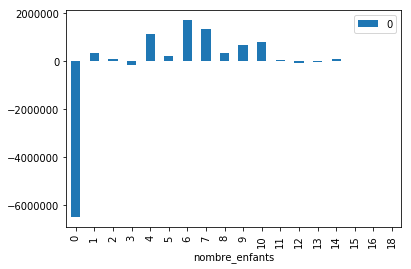

In [48]:
scenario.compute_pivot_table(
    aggfunc = 'sum', 
    values = ['impot_revenus'], 
    columns = ['nombre_enfants'],
    period = year,
    difference = True,
    ).stack().reset_index().plot(x = 'nombre_enfants', kind = 'bar')